<a href="https://colab.research.google.com/github/githubramkiran/LanggraphAgent/blob/main/LLM_bind_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qU "langchain-chroma>=0.1.2" langchain langchain-openai langgraph
!pip install -qU  langchain-google-genai langchain-community langchain-core
!pip install -U langchain-anthropic
!pip install -U langchain-google-vertexai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 8.9 MB/s eta 

In [ ]:
import os,getpass
#os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Enter your ANTHROPIC_API_KEY API key: ")
os.environ["GEMINI_API_KEY"] = getpass.getpass("Enter your Gemini API key: ")
#os.environ["LANGSMITH_TRACING"] = "true

Enter your Gemini API key: ··········


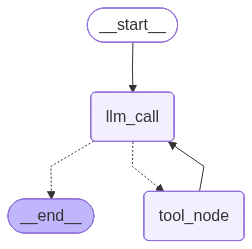

LLM call
Conditional edge should continue
Tool call
LLM call
Conditional edge should continue
================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (feac4fc1-4d7f-4131-a5e8-907165ac583b)
 Call ID: feac4fc1-4d7f-4131-a5e8-907165ac583b
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [ ]:
# Step 1: Define tools and model

from langchain.tools import tool
from langchain.chat_models import init_chat_model


model = init_chat_model(
    #"claude-sonnet-4-5-20250929",
    "google_genai:gemini-2.5-flash",
    temperature=0
)


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

# Step 2: Define state

from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

# Step 3: Define model node
from langchain.messages import SystemMessage


def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""
    print("LLM call")
    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }


# Step 4: Define tool node

from langchain.messages import ToolMessage


def tool_node(state: dict):
    """Performs the tool call"""
    print("Tool call")
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

# Step 5: Define logic to determine whether to end

from typing import Literal
from langgraph.graph import StateGraph, START, END


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""
    print("Conditional edge should continue")
    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

# Step 6: Build agent

# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()


from IPython.display import Image, display
# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
from langchain.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

In [ ]:
messages = [HumanMessage(content="Tell about ramkiran.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

LLM call
Conditional edge should continue
================================ Human Message =================================

Tell about ramkiran.
================================== Ai Message ==================================

[{'type': 'text', 'text': 'I am a large language model, able to communicate in response to a wide range of prompts and questions, but I am unable to provide information about specific individuals. Is there anything else I can do to help?', 'extras': {'signature': 'CvwCAXLI2nwTFKp+e9vRJQsvCkww+QNKRNlPD9UEM8ISBeLjd/dSb7hPS5GpMnVya+AQEar2SVw6ABvOXESCBH2gp/ThvG9DNrGaNXAQ/54Nj0HBlqwCDQDzC/GAlYn7t9GAxMfGUDhtGzj+DEBTyvfAXJUh7aOAvmmOgQSh+xm8Px937WVQ46JaWGqtSYNeK+cY+6d/8v3Exn3JDb5RTZ0Q8u6kFJKx6jaRun0fw0N9SAdcGlRmdz0d5dju4W+qch+9XM3lxvpI/zGY1laBy5ykrJtcF7xIgIJvdbC7VJxDcygIxloR/K1Da96CsY7P5lBc7dHclnH/e13CcRJvMBkAQiq5pWgjZRYhjrVZIu+LChinmef//Prm+fp0v2nzLvMXuYXQi5wz0zQX/VQFylAgqHgJCYXNy4k0rLf8UIgWlfZjRPmh9qPJK0WYaGPEZ7rs0bfrpbSahUaYufZypZWzIPmj80+3hKJgq4fYHFvAoJTk1FxmdaiCdxfk